In [1]:
import pandas as pd


df = pd.read_csv("data/preprocessed_train.csv", index_col="id")

In [2]:
df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511
5,0.594579,-11.715431,0.101701,0.000005,0.259634,0.024300,0.639254,161012.2221,0.938333,151.43602


In [3]:
y = df['BeatsPerMinute']
X = df.drop(columns=['BeatsPerMinute'])
X = X[['LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs']]

In [4]:
from sklearn.preprocessing import StandardScaler


X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.to_frame())

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [6]:
import torch
import torch.nn as nn


X_train_tensor = torch.from_numpy(X_train.values)
X_test_tensor = torch.from_numpy(X_test.values)
X_val_tensor = torch.from_numpy(X_val.values)

y_train_tensor = torch.from_numpy(y_train.values)
y_test_tensor = torch.from_numpy(y_test.values)
y_val_tensor = torch.from_numpy(y_val.values)

In [7]:
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)
y_val_tensor = y_val_tensor.unsqueeze(1)

In [8]:
X_train_tensor = X_train_tensor.to(torch.float32).to("mps")
X_test_tensor = X_test_tensor.to(torch.float32).to("mps")
X_val_tensor = X_val_tensor.to(torch.float32).to("mps")

y_train_tensor = y_train_tensor.to(torch.float32).to("mps")
y_test_tensor = y_test_tensor.to(torch.float32).to("mps")
y_val_tensor = y_val_tensor.to(torch.float32).to("mps")

In [9]:
model = nn.Sequential(
    nn.Linear(3, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.ReLU(),
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
model.to("mps")

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
)

In [11]:
num_epochs = 100

In [12]:
train_loss = []
val_loss = []

for n in range(num_epochs):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    train_loss.append(loss.cpu().detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred = model(X_val_tensor)
    loss = loss_fn(y_pred, y_val_tensor)
    val_loss.append(loss.cpu().detach())

In [13]:
from sklearn.metrics import root_mean_squared_error, r2_score


preds = model(X_test_tensor)
rmse = root_mean_squared_error(y_test_tensor.cpu().detach(), preds.cpu().detach())
r2 = r2_score(y_test_tensor.cpu().detach(), preds.cpu().detach())
print('rmse of the model is:', rmse)
print('r2 of the model is:', r2)

rmse of the model is: 120.92192077636719
r2 of the model is: -26.108192443847656


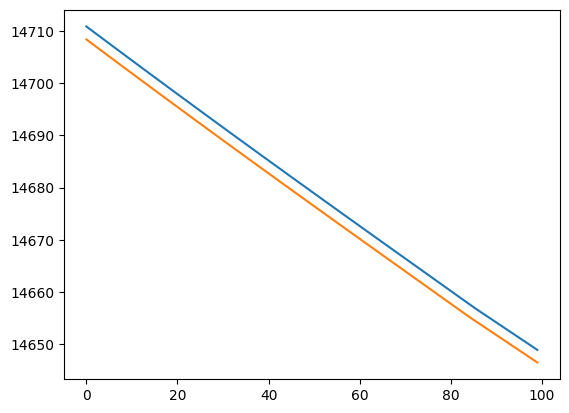

In [14]:
import matplotlib.pyplot as plt


plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(val_loss)), val_loss)